

# Low-level LSL API

.. include:: ./../../links.inc


LSL is a library designed for streaming time series data across different platforms and
programming languages. The [core library](lsl lib_) is primarily written in C++, and
bindings are accessible for Python, C#, Java, MATLAB, and Unity, among others. You can
find a comprehensive list [here](lsl language bindings_).

MNE-LSL provides a reimplementation of the [python binding](lsl python_), known as
``pylsl``, within the ``mne_lsl.lsl`` module. It introduces additional functionalities
to simplify the low-level interaction with LSL streams. Moreover, it enhances the
detection of liblsl on your system and can retrieve a compatible version online if
necessary. The differences between ``pylsl`` and ``mne_lsl.lsl`` are detailed
`here<resources/pylsl:Differences with pylsl>`.


In [1]:
import time
import uuid

from mne_lsl.lsl import (
    StreamInfo, StreamInlet, StreamOutlet, local_clock, resolve_streams
)
from pylsl import resolve_stream
import mne
import os,pandas as pd
import numpy as np
import pathlib


import logging

# For interactive plots
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')

# Define paths: 
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'


## Discover streams

At this point, the :class:`~mne_lsl.lsl.StreamOutlet` is available on the network. The
function :func:`~mne_lsl.lsl.resolve_streams` discovers all available streams on the
network. This operation is commonly named the stream resolution.

<div class="alert alert-info"><h4>Note</h4><p>The stream resolution can be restricted by providing the ``name``, ``stype``, and
    ``source_id`` arguments.</p></div>



In [2]:
streams = resolve_streams()

streams[:]

[< sInfo 'LiveAmpSN-101405-0905' >
   | Type: EEG
   | Sampling: 500.0 Hz
   | Number of channels: 67
   | Data type: <class 'numpy.float32'>
   | Source: LiveAmpSN-101405-0905]

The resolution retrieves only the stream basic properties. The channel properties,
stored in the stream description in an XML element tree, are absent from a
:class:`~mne_lsl.lsl.StreamInfo` returned by the resolution function.



In [3]:
assert streams[0].get_channel_names() is None

## Connect to a Stream

To connect to a stream, a :class:`~mne_lsl.lsl.StreamInlet` object must be created
using the resolved :class:`~mne_lsl.lsl.StreamInfo`. Once the stream is opened with
:meth:`~mne_lsl.lsl.StreamInlet.open_stream`, the connection is established and
both the properties and data become available.



In [4]:
inlet = StreamInlet(streams[0])
inlet.open_stream()
sinfo = inlet.get_sinfo()  # retrieve stream information with all properties

In [5]:
sinfo

< sInfo 'LiveAmpSN-101405-0905' >
  | Type: EEG
  | Sampling: 500.0 Hz
  | Number of channels: 67
  | Data type: <class 'numpy.float32'>
  | Source: LiveAmpSN-101405-0905

In [6]:
ch_names = sinfo.get_channel_names()

In [7]:
types = sinfo.get_channel_types()

In [8]:
sinfo.get_channel_units()

['microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'microvolts',
 'milliGs',
 'milliGs',
 'milliGs']

An :class:`mne.Info` can be obtained directly with
:meth:`~mne_lsl.lsl.StreamInfo.get_channel_info`. If the information contained in the
XML element tree can not be parsed, default values are used. For instance, the channel
names are replaced by the channel numbers similarly to :func:`mne.create_info`.



In [9]:
sinfo.get_channel_info()

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,67 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [10]:
Info = mne.create_info (sinfo.n_channels,sinfo.sfreq,'eeg')

# Ensure the channel names are in the expected format (0 to 66)
original_channel_names = [f'{i}' for i in range(67)]  # Adjust if necessary

# New channel names you provided
new_channel_names = [
    "Fp1", "Fz", "F3", "F7", "FT9", "FC5", "FC1", "C3", "T7",
    "CP5", "CP1", "Pz", "P3", "P7", "TP9", "O1", "Oz", "O2", "TP10",
    "P8", "P4", "CP2", "CP6", "T8", "C4", "Cz", "FC2", "FC6", "FT10",
    "F8", "F4", "Fp2", "AF7", "AF3", "AFz", "F1", "F5", "FT7", "FC3",
    "C1", "C5", "TP7", "CP3", "P1", "P5", "PO7", "PO3", "POz", "PO4",
    "PO8", "P6", "P2", "CPz", "CP4", "TP8", "C6", "C2", "FC4", "FT8",
    "F6", "AF8", "AF4", "F2", "Iz", "ACC_X", "ACC_Y", "ACC_Z"
]

# Check if the original file has extra channels or is missing any, and adjust accordingly
#assert len(Raw.ch_names) >= len(original_channel_names), "The raw file has fewer channels than expected."

# Mapping from original to new names
channel_mapping = dict(zip(original_channel_names, new_channel_names))
montage = mne.channels.read_custom_montage((f"{current_path}\Montages\CACS-64_REF.bvef"), head_size=0.095, coord_frame=None) 


## Creating a stream

To create a stream, you must first define its properties. This is achieved by creating
a :class:`~mne_lsl.lsl.StreamInfo` object, which specifies the stream's name, type,
source and properties. Convenience methods are available to set the channel
properties, including :meth:`~mne_lsl.lsl.StreamInfo.set_channel_info`, which uses a
:class:`mne.Info` object as source.



In [11]:
sdinfo = StreamInfo(
    name="Prediction_stream",
    stype="Markers",
    n_channels=1,
    sfreq=0,
    dtype="string",
    source_id=uuid.uuid4().hex[:6],
)
info = StreamInfo(name='Prediction_stream', stype='Markers', n_channels=1, sfreq=0, dtype='string', source_id='my_source_id')


Once the :class:`~mne_lsl.lsl.StreamInfo` object is created, a
:class:`~mne_lsl.lsl.StreamOutlet` can be instantiated to create the stream.



In [12]:
info

< sInfo 'Prediction_stream' >
  | Type: Markers
  | Sampling: Irregular
  | Number of channels: 1
  | Data type: string
  | Source: my_source_id

In [13]:
outlet = StreamOutlet(info)

In [26]:
import pickle 
fname = 'Ron_14_01_4CSP'

path_fname = current_path /'Models'/ fname
#%% Load the selected model

#read the pickle file   
picklefile = open(path_fname, 'rb')
#unpickle the dataframe
trained_clf_1 = pickle.load(picklefile)
#close file
picklefile.close()

fname = 'NH_3rd_arm'+'_FBCSP_model_Close+0910'

path_fname = current_path /'Models'/ fname
#%% Load the selected model

#read the pickle file   
picklefile = open(path_fname, 'rb')
#unpickle the dataframe
trained_clf_2 = pickle.load(picklefile)
#close file
picklefile.close()

fname = 'electrode_picks-1401'
path_fname = current_path /'Models'/ fname
#create a pickle file
picklefile = open(path_fname, 'rb')
#pickle the diction.
# ary and write it to file
picks = pickle.load(picklefile)
#close the file

picklefile.close()

fname = 'mean'
path_fname = current_path /'Models'/ fname
#create a pickle file
picklefile = open(path_fname, 'rb')
#pickle the dictionary and write it to file
mean = pickle.load(picklefile)
#close the file

picklefile.close()

In [16]:

def check_thresholds(thresholded_prediction, thresholds):
    """
    Check if each class's prediction is above the designated threshold for each instance.

    Args:
        thresholded_prediction (np.ndarray): The decision function output for the instances (shape: (n_instances, 3)).
        thresholds (np.ndarray): The thresholds for each class (shape: (3,)).

    Returns:
        List[str]: List of strings indicating the classification for each instance.
    """
    if thresholded_prediction.shape[1] != thresholds.shape[0]:
        raise ValueError("Number of classes in thresholded_prediction and thresholds must be the same.")

    # Perform thresholding
    bool_predictions = thresholded_prediction > thresholds
    
    results = []
    for pred in bool_predictions:
        if np.array_equal(pred, [True, False, False]):
            results.append('Left')
        elif np.array_equal(pred, [False, True, False]):
            results.append('Rest')
        elif np.array_equal(pred, [False, False, True]):
            results.append('Right')
        elif np.array_equal(pred, [True, False, True]):
            results.append('MI')
        elif np.array_equal(pred, [False, False, False]):
            results.append('Nothing')
        else:
            results.append('Indecisive')
    
    return results



Stuff for FBCSP

In [17]:
#extract filterbank feequencies:

filters_bands=tuple([[7, 12], [12, 20], [20, 28], [28, 35]])
filtered_data_band_passed=[]
#for i,(LowPass,HighPass) in enumerate(filters_bands):
#     unfiltered_Raw_CSD=Raw_CSD.copy()
#     Raw_CSD_Filtered_band= unfiltered_Raw_CSD.filter(LowPass, HighPass, method='fir')
#     filtered_data_band_passed.append(Raw_CSD_Filtered_band)

In [18]:
from concurrent.futures import ThreadPoolExecutor
# Function to apply band-pass filter
def filter_band(raw_csd, band):
    LowPass, HighPass = band
    return raw_csd().filter(LowPass, HighPass, method='fir', copy = True)

In [19]:
# Function to add an annotation to the stream_annotations
def add_stream_annotation(onset, description, duration=0):
    new_annotation = mne.Annotations(onset=[onset], duration=[duration], description=[description])
    stream_annotations += new_annotation  # This merges the new annotation with the existing ones


In [20]:
def check_probabilitiy(probabilities):
    """
    Check the probability for each class and return the corresponding label for a single instance.

    Args:
        probabilities (np.ndarray): The probability predictions for a single instance (shape: (1, 3)).

    Returns:
        str: The classification result for the instance.
    """
    if probabilities.shape != (1, 3):
        raise ValueError("Input probabilities must be of shape (1, 3).")

    prob = probabilities[0]
    
    if prob[0] >= 0.80:
        return 'Left'
    elif prob[2] >= 0.80:
        return 'Right'
    elif prob[1] >= 0.70:
        return 'Rest'
    else:
        return 'Indecisive'


In [21]:

def check_probabilities(probabilities_list):
    """
    Check the probability for each class and return the corresponding label for each instance.

    Args:
        probabilities_list (list of np.ndarray): A list of probability predictions for each instance, 
                                                 where each element is an array of shape (1, 3).

    Returns:
        List[str]: List of strings indicating the classification for each instance.
    """
    results = []
    for probabilities in probabilities_list:
        if probabilities.shape != (1, 3):
            raise ValueError("Each element in probabilities_list must be of shape (1, 3).")
        
        prob = probabilities[0]
        
        if prob[0] >= 0.80:
            results.append('Left')
        elif prob[2] >= 0.80:
            results.append('Right')
        elif prob[1] >= 0.70:
            results.append('Rest')
        else:
            results.append('Indecisive')
    
    return results

# Example usage
probabilities_list = [
    np.array([[1.71081177e-18, 1.00000000e+00, 8.00656264e-17]]),
    np.array([[4.97241401e-07, 9.99942853e-01, 5.66500420e-05]]),
    np.array([[0.7486333 , 0.00369888, 0.24766782]]),
    np.array([[0.44347274, 0.0404159 , 0.51611136]]),
    np.array([[0.00426725, 0.0656531 , 0.93007965]]),
    np.array([[0.01139173, 0.26943693, 0.71917134]]),
    np.array([[0.016324  , 0.32737299, 0.65630301]]),
    np.array([[0.08135061, 0.45637327, 0.46227612]]),
    np.array([[0.10260846, 0.53147955, 0.36591199]]),
    np.array([[0.23376032, 0.38045596, 0.38578372]]),
    np.array([[0.17443305, 0.32022263, 0.50534432]]),
    np.array([[0.21976654, 0.3204963 , 0.45973716]]),
    np.array([[0.33616824, 0.16463337, 0.49919839]]),
    np.array([[0.38205565, 0.18543537, 0.43250898]]),
    np.array([[0.25574611, 0.25772795, 0.48652593]]),
    np.array([[0.34309578, 0.17076746, 0.48613676]]),
    np.array([[0.40237776, 0.18798245, 0.40963979]]),
    np.array([[0.42509685, 0.17965781, 0.39524534]]),
    np.array([[0.53220171, 0.09821765, 0.36958065]]),
    np.array([[0.57345818, 0.08547533, 0.34106649]]),
    np.array([[0.67375271, 0.08464682, 0.24160047]]),
    np.array([[0.73264316, 0.06609203, 0.20126481]])
]

result = check_probabilities(predictions_proba)
print(result)


NameError: name 'predictions_proba' is not defined

In [22]:

def check_probabilities(probabilities):
    """
    Check the probability for each class and return the corresponding label.

    Args:
        probabilities (np.ndarray): The probability predictions for the instances (shape: (n_instances, 3)).

    Returns:
        List[str]: List of strings indicating the classification for each instance.
    """
    results = []
    for prob in probabilities:
        if prob[0] >= 0.80:
            results.append('Left')
        elif prob[2] >= 0.80:
            results.append('Right')
        elif prob[1] >= 0.70:
            results.append('Rest')
        else:
            results.append('Indecisive')
    
    return results

# Example usage
probabilities = np.array([[0.00325599, 0.99360915, 0.00313486],
                          [0.85, 0.10, 0.05],
                          [0.10, 0.75, 0.15],
                          [0.60, 0.20, 0.20],
                          [0.05, 0.10, 0.85]])

result = check_probabilities(prediction_proba)
print(result)  # Output: ['Rest', 'Left', 'Rest', 'Indecisive', 'Right']


NameError: name 'prediction_proba' is not defined

In [22]:
# give a bit of time to the documentation build after the execution of the last cell
inlet.flush()
time.sleep(0.2)
concat_data = np.empty((0, 67))  # Initialize with zero samples but correct channel count
storage_concat_data = np.empty((0, 67))  # Initialize with zero samples but correct channel count
last_pushed_sample = (['StreamStart'])  # Assuming ActiveRest as the initial state


#assert inlet.samples_available == 1
# Initialize an empty Annotations object
stream_annotations = mne.Annotations(onset=[], duration=[], description=[])

duration = 720
predictions =[]
predictions2 =[]

predictions_proba = []
max_samples = 55
start_time = time.time()
while time.time() - start_time < duration:
    while(inlet.samples_available<101):
        time.sleep(0.001)
    data,ts = inlet.pull_chunk(max_samples=max_samples)
    if ((concat_data.shape)[0]>5000):
        concat_data = concat_data[-2500:]  # Reset 'concat_data' after a while for preprocessing
    concat_data = np.concatenate((concat_data, data), axis=0)
    #For debuging
    #storage_concat_data = np.concatenate((storage_concat_data, data), axis=0)
    now = local_clock()
    print(f"Timestamp of the acquired data: {ts[max_samples-1]}")
    print(f"Current time: {now}")
    print(f"Delta: {now - ts[max_samples-1]} seconds")
    
    # Temporary suppress logging output
    original_log_level = logging.getLogger('mne').getEffectiveLevel()
    logging.getLogger('mne').setLevel(logging.ERROR)  # Suppress messages below ERROR level

    Raw=mne.io.RawArray(concat_data.T,Info)
    # Calculate the time of the last sample
    last_sample_time = time.time() - start_time

    # Rename channels
    Raw.rename_channels(channel_mapping)
    #mne.rename_channels(Raw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
    Raw.drop_channels(['ACC_X','ACC_Y','ACC_Z']) ## Drop non eeg channels
    Raw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)
    Raw._data /= 1e6
    Raw_CSD = mne.preprocessing.compute_current_source_density(Raw) ## Compute CSD
    Raw_CSD.pick(picks)
    unfiltered_Raw = Raw_CSD.copy()
    #Raw_CSD_Filtered = Raw_CSD.filter(5, 35, method='fir')
    
    filtered_data_band_passed=[]
    for i,(LowPass,HighPass) in enumerate(filters_bands):
        Raw_CSD_Filtered_band= mne.filter.filter_data(unfiltered_Raw.get_data(),sfreq = 500, l_freq = LowPass, h_freq=HighPass, method='fir',copy = True)
        filtered_data_band_passed.append(Raw_CSD_Filtered_band)
    
    #Output_data = Raw_CSD_Filtered.get_data()

    Output_data= np.transpose(np.array(filtered_data_band_passed),(1,2,0))
    #Output_data= (Raw_CSD_Filtered.get_data())
    Output_data = Output_data[:, -500:,:]
    Output_data = Output_data[np.newaxis, :, :,:]

    # Determine the total number of samples
    #n_samples = Raw_CSD_Filtered.n_times

    # We want the last X samples
    #samples_to_get = 251

    # Calculate the start sample to get the last 55 samples
    #start_sample = n_samples - samples_to_get
    # Use the .get_data() method to get the last 55 samples
    # Assuming you want to get data for all channels, otherwise specify picks=[channel_indices]
    #data_for_classification = filtered_data_band_passed.get_data(start=start_sample, stop=n_samples)
    data_for_classification = Output_data

    # Restore original logging level
    logging.getLogger('mne').setLevel(original_log_level)
    prediction_decision_function = trained_clf_1.decision_function(data_for_classification)
    prediction_proba = trained_clf_1.predict_proba(data_for_classification)
    #print (prediction)
    #prediction = check_thresholds(prediction_decision_function,thresholds)

    # Initialize the variable to store the last pushed sample
    # Initialize the variable to store the last pushed sample

    # Get predictions from both classifiers
    prediction = trained_clf_1.predict(data_for_classification)
    prediction2 = trained_clf_2.predict(data_for_classification)

    # Append the current predictions to the prediction history
    predictions.append(prediction)
    predictions2.append(prediction2)

    # Check if both predictions agree on non-ActiveRest
    if len(predictions) > 1:
        if (prediction2[0] != 'ActiveRest') and (prediction[0] != 'ActiveRest'):
            # Only push and update annotation if this prediction is different from the last pushed one
            if last_pushed_sample != (['MotorImagery']):
                # Create an annotation at the last sample time
                new_annotations = mne.Annotations(onset=[last_sample_time], duration=[0], description=['MotorImagery'])
                # Add the annotation to the Raw object
                stream_annotations += new_annotations  # This merges the new annotation with the existing ones
                outlet.push_sample([prediction[0]])
                # Update the last pushed sample
                last_pushed_sample = (['MotorImagery'])
        else:
            # Default to ActiveRest if predictions are not in agreement or one is ActiveRest
            if last_pushed_sample != (['ActiveRest']):
                new_annotations = mne.Annotations(onset=[last_sample_time], duration=[0], description=["ActiveRest"])
                stream_annotations += new_annotations  # This merges the new annotation with the existing ones
                outlet.push_sample(['ActiveRest'])
                # Update the last pushed sample
                last_pushed_sample = (['ActiveRest'])
    else:
        outlet.push_sample(last_pushed_sample)

    print (last_pushed_sample[0])
    #predictions_proba.append(prediction_proba)
    # Push processed data chunk for classification
    #assert inlet.samples_available == 0


Timestamp of the acquired data: 1569221.1264474
Current time: 1569221.2270669
Delta: 0.1006195000372827 seconds


ValueError: shapes (4,34) and (20,55) not aligned: 34 (dim 1) != 20 (dim 0)

In [54]:
# give a bit of time to the documentation build after the execution of the last cell
inlet.flush()
time.sleep(0.2)
concat_data = np.empty((0, 67))  # Initialize with zero samples but correct channel count
#storage_concat_data = np.empty((0, 67))  # Initialize with zero samples but correct channel count
#assert inlet.samples_available == 1
# Initialize an empty Annotations object
stream_annotations = mne.Annotations(onset=[], duration=[], description=[])

duration = 720
predictions =[]
predictions_proba = []
max_samples = 55
start_time = time.time()
while time.time() - start_time < duration:
    while(inlet.samples_available<56):
        time.sleep(0.001)
    data,ts = inlet.pull_chunk(max_samples=max_samples)
    if ((concat_data.shape)[0]>5000):
        concat_data = concat_data[-2500:]  # Reset 'concat_data' after a while for preprocessing 
        outlet.push_sample(["Reset"])
    concat_data = np.concatenate((concat_data, data), axis=0)
    #For debuging
    #storage_concat_data = np.concatenate((storage_concat_data, data), axis=0)
    now = local_clock()
    print(f"Timestamp of the acquired data: {ts[max_samples-1]}")
    print(f"Current time: {now}")
    print(f"Delta: {now - ts[max_samples-1]} seconds")
    
    # Temporary suppress logging output
    original_log_level = logging.getLogger('mne').getEffectiveLevel()
    logging.getLogger('mne').setLevel(logging.ERROR)  # Suppress messages below ERROR level

    Raw=mne.io.RawArray(concat_data.T,Info)
    # Calculate the time of the last sample
    last_sample_time = time.time() - start_time

    # Rename channels
    Raw.rename_channels(channel_mapping)
    #mne.rename_channels(Raw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
    Raw.drop_channels(['ACC_X','ACC_Y','ACC_Z']) ## Drop non eeg channels
    Raw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)
    Raw._data /= 1e6
    Raw_CSD = mne.preprocessing.compute_current_source_density(Raw) ## Compute CSD
    Raw_CSD.pick(picks)
    unfiltered_Raw = Raw_CSD.copy()
    #Raw_CSD_Filtered = Raw_CSD.filter(5, 35, method='fir')
    
    filtered_data_band_passed=[]
    for i,(LowPass,HighPass) in enumerate(filters_bands):
        Raw_CSD_Filtered_band= mne.filter.filter_data(unfiltered_Raw.get_data(),sfreq = 500, l_freq = LowPass, h_freq=HighPass, method='fir',copy = True)
        filtered_data_band_passed.append(Raw_CSD_Filtered_band)
    
    # #Output_data = Raw_CSD_Filtered.get_data()

    Output_data= np.transpose(np.array(filtered_data_band_passed),(1,2,0))
    #Output_data= (Raw_CSD_Filtered.get_data())
    Output_data = Output_data[:, -1001:,:]
    Output_data = Output_data[np.newaxis, :, :,:]

    # Determine the total number of samples
    #n_samples = Raw_CSD_Filtered.n_times

    # We want the last X samples
    #samples_to_get = 251

    # Calculate the start sample to get the last 55 samples
    #start_sample = n_samples - samples_to_get
    # Use the .get_data() method to get the last 55 samples
    #Assuming you want to get data for all channels, otherwise specify picks=[channel_indices]
    #data_for_classification = filtered_data_band_passed.get_data(start=start_sample, stop=n_samples)
    data_for_classification = Output_data

    # Restore original logging level
    logging.getLogger('mne').setLevel(original_log_level)
    prediction_decision_function = trained_clf_1.decision_function(data_for_classification)
    prediction_proba = trained_clf_1.predict_proba(data_for_classification)
    #print (prediction)
    #prediction = check_thresholds(prediction_decision_function,thresholds)
    prediction=trained_clf_1.predict(data_for_classification)
    if len(predictions)>1:
        if (predictions[-1:][0][0] != prediction[0]):
            # Create an annotation at the last sample time
            new_annotations = mne.Annotations(onset=[last_sample_time], duration=[0], description=[prediction[0]])
            # Add the annotation to the Raw object
            stream_annotations += new_annotations  # This merges the new annotation with the existing ones
            outlet.push_sample([prediction[0]])

    print(prediction[0])
    predictions.append(prediction)
    #predictions_proba.append(prediction_proba)
    # Push processed data chunk for classification
    #assert inlet.samples_available == 0


Timestamp of the acquired data: 1672094.906447
Current time: 1672094.9093052
Delta: 0.002858199877664447 seconds
ClosePalm
Timestamp of the acquired data: 1672095.0164471
Current time: 1672095.02222
Delta: 0.005772899836301804 seconds
ClosePalm
Timestamp of the acquired data: 1672095.1264472
Current time: 1672095.1524093
Delta: 0.02596209989860654 seconds
ClosePalm
Timestamp of the acquired data: 1672095.2364471
Current time: 1672095.2481819
Delta: 0.011734799947589636 seconds
ClosePalm
Timestamp of the acquired data: 1672095.3464471
Current time: 1672095.367924
Delta: 0.021476899972185493 seconds
ClosePalm
Timestamp of the acquired data: 1672095.4564484
Current time: 1672095.4625883
Delta: 0.00613990006968379 seconds
ClosePalm
Timestamp of the acquired data: 1672095.5664471
Current time: 1672095.5783169
Delta: 0.011869800044223666 seconds
ActiveRest
Timestamp of the acquired data: 1672095.6764476
Current time: 1672095.698541
Delta: 0.022093400126323104 seconds
ActiveRest
Timestamp of 

In [40]:
Raw_CSD.info.ch_names

['FC5',
 'FC3',
 'FC1',
 'FC2',
 'FC4',
 'FC6',
 'C5',
 'C3',
 'C1',
 'Cz',
 'C2',
 'C4',
 'C6',
 'CP5',
 'CP3',
 'CP1',
 'CPz',
 'CP2',
 'CP4',
 'CP6',
 'P7',
 'P5',
 'P3',
 'P1',
 'Pz',
 'P2',
 'P4',
 'P6',
 'P8',
 'PO7',
 'PO3',
 'POz',
 'PO4',
 'PO8']

In [132]:
result = check_probabilitiy(prediction_proba)
print(result)  # Output: 'Rest

ValueError: Input probabilities must be of shape (1, 3).

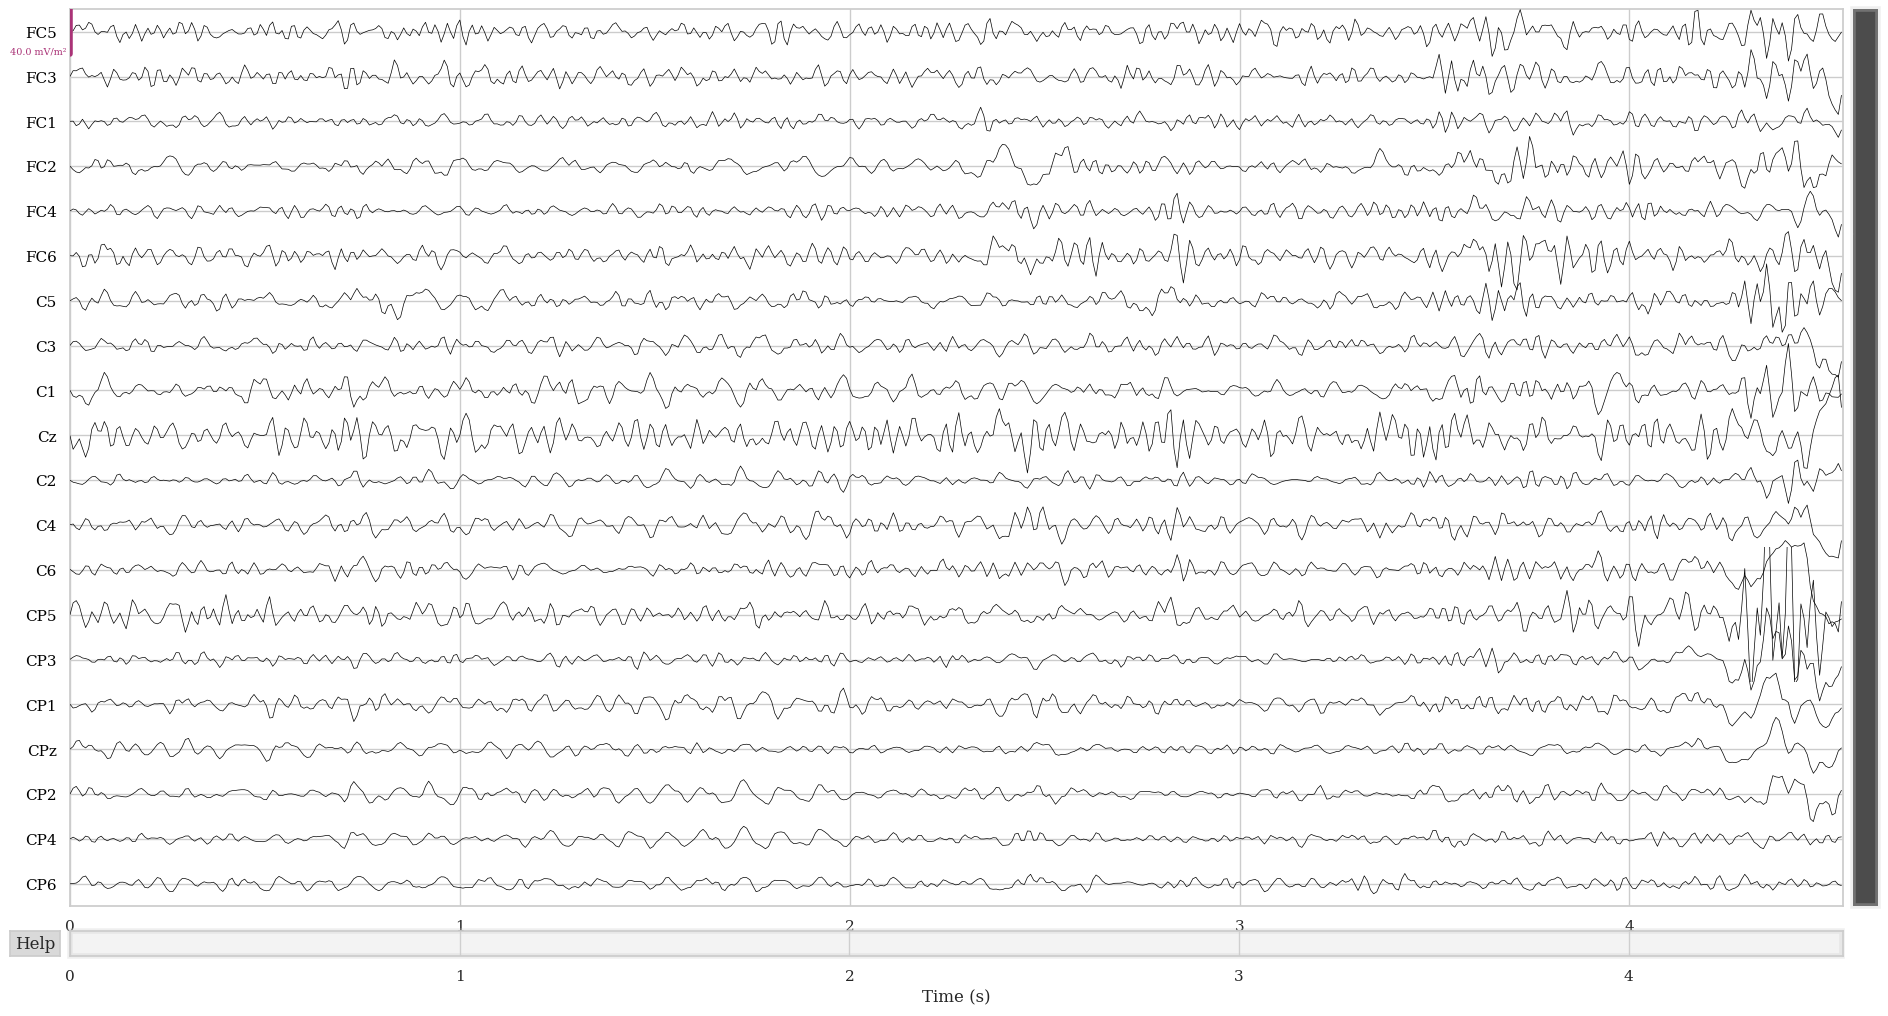

In [81]:
Raw_CSD_Filtered.plot()

In [30]:
# give a bit of time to the documentation build after the execution of the last cell
inlet.flush()
time.sleep(0.2)
concat_data = np.empty((0, 67))  # Initialize with zero samples but correct channel count
storage_concat_data = np.empty((0, 67))  # Initialize with zero samples but correct channel count
#assert inlet.samples_available == 1
# Initialize an empty Annotations object
stream_annotations = mne.Annotations(onset=[], duration=[], description=[])

duration = 720
predictions =[]
predictions_proba = []
max_samples = 55
start_time = time.time()
while time.time() - start_time < duration:
    while(inlet.samples_available<101):
        time.sleep(0.001)
    data,ts = inlet.pull_chunk(max_samples=max_samples)
    if ((concat_data.shape)[0]>5000):
        concat_data = concat_data[-2500:]  # Reset 'concat_data' after a while for preprocessing
    concat_data = np.concatenate((concat_data, data), axis=0)
    #For debuging
    storage_concat_data = np.concatenate((storage_concat_data, data), axis=0)
    now = local_clock()
    print(f"Timestamp of the acquired data: {ts[max_samples-1]}")
    print(f"Current time: {now}")
    print(f"Delta: {now - ts[max_samples-1]} seconds")
    
    # Temporary suppress logging output
    original_log_level = logging.getLogger('mne').getEffectiveLevel()
    logging.getLogger('mne').setLevel(logging.ERROR)  # Suppress messages below ERROR level

    Raw=mne.io.RawArray(concat_data.T,Info)
    # Calculate the time of the last sample
    last_sample_time = time.time() - start_time

    # Rename channels
    Raw.rename_channels(channel_mapping)
    #mne.rename_channels(Raw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
    Raw.drop_channels(['ACC_X','ACC_Y','ACC_Z','FT10', 'TP10', 'FT9', 'TP9','Iz']) ## Drop non eeg channels
    Raw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)
    Raw._data /= 1e6
    Raw_CSD = mne.preprocessing.compute_current_source_density(Raw) ## Compute CSD
    Raw_CSD.pick(picks)
    unfiltered_Raw = Raw_CSD.copy()
    Raw_CSD_Filtered = Raw_CSD.filter(5, 35, method='fir')
    
    # filtered_data_band_passed=[]
    # for i,(LowPass,HighPass) in enumerate(filters_bands):
    #     Raw_CSD_Filtered_band= mne.filter.filter_data(Raw_CSD_Filtered.get_data(),sfreq = 500, l_freq = LowPass, h_freq=HighPass, method='fir',copy = True)
    #     filtered_data_band_passed.append(Raw_CSD_Filtered_band)
    
    #Output_data = Raw_CSD_Filtered.get_data()

    # Output_data= np.transpose(np.array(filtered_data_band_passed),(1,2,0))
    Output_data= (Raw_CSD_Filtered.get_data())
    # Calculate the mean across epochs for the current event
    #mean_across_event_epochs = Output_data.mean(axis=0)
    
    # Subtract the mean from each epoch of the current event
    #Output_data = Output_data - mean_across_event_epochs
    Output_data = Output_data[:, -500:]
    Output_data = Output_data[np.newaxis, :, :]

    # Determine the total number of samples
    #n_samples = Raw_CSD_Filtered.n_times

    # We want the last X samples
    #samples_to_get = 251

    # Calculate the start sample to get the last 55 samples
    #start_sample = n_samples - samples_to_get
    # Use the .get_data() method to get the last 55 samples
    # Assuming you want to get data for all channels, otherwise specify picks=[channel_indices]
    #data_for_classification = filtered_data_band_passed.get_data(start=start_sample, stop=n_samples)
    data_for_classification = Output_data

    # Restore original logging level
    logging.getLogger('mne').setLevel(original_log_level)
    prediction_decision_function = trained_clf_1.decision_function(data_for_classification)
    prediction_proba = trained_clf_1.predict_proba(data_for_classification)
    #print (prediction)
    #prediction = check_thresholds(prediction_decision_function,thresholds)
    prediction=trained_clf_1.predict(data_for_classification)
    if len(predictions)>1:
        if (predictions[-1:][0][0] != prediction[0]):
            # Create an annotation at the last sample time
            new_annotations = mne.Annotations(onset=[last_sample_time], duration=[0], description=[prediction[0]])
            # Add the annotation to the Raw object
            stream_annotations += new_annotations  # This merges the new annotation with the existing ones
            outlet.push_sample([prediction[0]])

    print(prediction[0])
    predictions.append(prediction)
    #predictions_proba.append(prediction_proba)
    # Push processed data chunk for classification
    #assert inlet.samples_available == 0


Timestamp of the acquired data: 180395.5353195
Current time: 180395.6547455
Delta: 0.11942600001930259 seconds
ClosePalm
Timestamp of the acquired data: 180395.64512720003
Current time: 180395.774266
Delta: 0.12913879996631294 seconds
ClosePalm
Timestamp of the acquired data: 180395.755546
Current time: 180395.8546388
Delta: 0.0990927999955602 seconds
ClosePalm
Timestamp of the acquired data: 180395.86429820003
Current time: 180395.9741662
Delta: 0.10986799997044727 seconds
ClosePalm
Timestamp of the acquired data: 180395.9772526
Current time: 180396.0818122
Delta: 0.104559600003995 seconds
ClosePalm
Timestamp of the acquired data: 180396.08695080003
Current time: 180396.1954497
Delta: 0.1084988999646157 seconds
ActiveRest
Timestamp of the acquired data: 180396.19465250007
Current time: 180396.2966476
Delta: 0.1019950999179855 seconds
ActiveRest
Timestamp of the acquired data: 180396.30507420003
Current time: 180396.4166598
Delta: 0.11158559995237738 seconds
ActiveRest
Timestamp of the

KeyboardInterrupt: 

In [27]:
# Define an EMA class for dynamic mean updates
class ExponentialMovingAverage:
    def __init__(self, alpha, num_channels):
        self.alpha = alpha  # Smoothing factor (0 < alpha <= 1)
        self.mean = np.zeros(num_channels)  # Initialize mean with zeros

    def update(self, new_data):
        # Calculate mean across the sample dimension, keeping one mean per channel
        new_mean = new_data.mean(axis=1)  # Average across samples for each channel
        self.mean = self.alpha * new_mean + (1 - self.alpha) * self.mean
        return self.mean
# Parameters
alpha = 0.01  # EMA weight factor, adjust based on desired sensitivity to new data
num_channels = len(picks)  # Number of channels in the data
first_run = True

# give a bit of time to the documentation build after the execution of the last cell
inlet.flush()
time.sleep(0.2)
concat_data = np.empty((0, 67))  # Initialize with zero samples but correct channel count
storage_concat_data = np.empty((0, 67))  # Initialize with zero samples but correct channel count
#assert inlet.samples_available == 1
# Initialize an empty Annotations object
stream_annotations = mne.Annotations(onset=[], duration=[], description=[])

duration = 480
predictions =[]
predictions_proba = []
max_samples = 55
start_time = time.time()
while time.time() - start_time < duration:
    while(inlet.samples_available<101):
        time.sleep(0.001)
    data,ts = inlet.pull_chunk(max_samples=max_samples)
    if ((concat_data.shape)[0]>5000):
        concat_data = concat_data[-2500:]  # Reset 'concat_data' after a while for preprocessing
    concat_data = np.concatenate((concat_data, data), axis=0)
    #For debuging
    storage_concat_data = np.concatenate((storage_concat_data, data), axis=0)
    now = local_clock()
    print(f"Timestamp of the acquired data: {ts[max_samples-1]}")
    print(f"Current time: {now}")
    print(f"Delta: {now - ts[max_samples-1]} seconds")
    
    # Temporary suppress logging output
    original_log_level = logging.getLogger('mne').getEffectiveLevel()
    logging.getLogger('mne').setLevel(logging.ERROR)  # Suppress messages below ERROR level

    Raw=mne.io.RawArray(concat_data.T,Info)
    # Calculate the time of the last sample
    last_sample_time = time.time() - start_time

    # Rename channels
    Raw.rename_channels(channel_mapping)
    #mne.rename_channels(Raw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
    Raw.drop_channels(['ACC_X','ACC_Y','ACC_Z','FT10', 'TP10', 'FT9', 'TP9','Iz']) ## Drop non eeg channels
    Raw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)
    Raw._data /= 1e6
    Raw_CSD = mne.preprocessing.compute_current_source_density(Raw) ## Compute CSD
    Raw_CSD.pick(picks)
    unfiltered_Raw = Raw_CSD.copy()
    Raw_CSD_Filtered = Raw_CSD.filter(5, 35, method='fir')
    
    # filtered_data_band_passed=[]
    # for i,(LowPass,HighPass) in enumerate(filters_bands):
    #     Raw_CSD_Filtered_band= mne.filter.filter_data(Raw_CSD_Filtered.get_data(),sfreq = 500, l_freq = LowPass, h_freq=HighPass, method='fir',copy = True)
    #     filtered_data_band_passed.append(Raw_CSD_Filtered_band)
    
    #Output_data = Raw_CSD_Filtered.get_data()

    # Output_data= np.transpose(np.array(filtered_data_band_passed),(1,2,0))
    Output_data= (Raw_CSD_Filtered.get_data())
    if ((concat_data.shape)[0]<2500):
        pass
    else:
        if not(first_run):
            # Calculate the EMA-based mean across the event
            mean_across_event_epochs = ema_mean.update(Output_data)  # Update mean using EMA
        else:
            # Instantiate the EMA object
            ema_mean = ExponentialMovingAverage(alpha=alpha, num_channels=num_channels)
            mean_across_event_epochs = Output_data.mean(axis=1)
       
        # Center the data by subtracting the updated mean
        Output_data = Output_data - mean_across_event_epochs[:, np.newaxis]  # Broadcasting over samples
        Output_data = Output_data[:, -1001:]
        Output_data = Output_data[np.newaxis, :, :]

        # Determine the total number of samples
        #n_samples = Raw_CSD_Filtered.n_times

        # We want the last X samples
        #samples_to_get = 251

        # Calculate the start sample to get the last 55 samples
        #start_sample = n_samples - samples_to_get
        # Use the .get_data() method to get the last 55 samples
        # Assuming you want to get data for all channels, otherwise specify picks=[channel_indices]
        #data_for_classification = filtered_data_band_passed.get_data(start=start_sample, stop=n_samples)
        data_for_classification = Output_data

        # Restore original logging level
        logging.getLogger('mne').setLevel(original_log_level)
        prediction_decision_function = trained_clf_1.decision_function(data_for_classification)
        prediction_proba = trained_clf_1.predict_proba(data_for_classification)
        #print (prediction)
        #prediction = check_thresholds(prediction_decision_function,thresholds)
        prediction=trained_clf_1.predict(data_for_classification)
        if (first_run):
            new_annotations = mne.Annotations(onset=[last_sample_time], duration=[0], description=[prediction[0]])
            # Add the annotation to the Raw object
            stream_annotations += new_annotations  # This merges the new annotation with the existing ones
            outlet.push_sample([prediction[0]])
            first_run = False
        if len(predictions)>1:
            if (predictions[-1:][0][0] != prediction[0]):
                # Create an annotation at the last sample time
                new_annotations = mne.Annotations(onset=[last_sample_time], duration=[0], description=[prediction[0]])
                # Add the annotation to the Raw object
                stream_annotations += new_annotations  # This merges the new annotation with the existing ones
                outlet.push_sample([prediction[0]])

        print(prediction[0])
        predictions.append(prediction)
        #predictions_proba.append(prediction_proba)
        # Push processed data chunk for classification
        #assert inlet.samples_available == 0


Timestamp of the acquired data: 180123.9462289
Current time: 180124.0865924
Delta: 0.14036350001697429 seconds
Timestamp of the acquired data: 180124.05738550003
Current time: 180124.1851637
Delta: 0.1277781999669969 seconds
Timestamp of the acquired data: 180124.1659431
Current time: 180124.2968542
Delta: 0.13091109998640604 seconds
Timestamp of the acquired data: 180124.2815277
Current time: 180124.3731627
Delta: 0.0916350000188686 seconds
Timestamp of the acquired data: 180124.38623730003
Current time: 180124.5140189
Delta: 0.12778159996378236 seconds
Timestamp of the acquired data: 180124.496357
Current time: 180124.6365682
Delta: 0.14021119999233633 seconds
Timestamp of the acquired data: 180124.60843660004
Current time: 180124.715949
Delta: 0.10751239996170625 seconds
Timestamp of the acquired data: 180124.7169759
Current time: 180124.8402131
Delta: 0.12323719999403693 seconds
Timestamp of the acquired data: 180124.82714600005
Current time: 180124.9967928
Delta: 0.169646799942711

KeyboardInterrupt: 

In [69]:
# give a bit of time to the documentation build after the execution of the last cell
inlet.flush()
time.sleep(0.2)
concat_data = np.empty((0, 67))  # Initialize with zero samples but correct channel count
storage_concat_data = np.empty((0, 67))  # Initialize with zero samples but correct channel count
#assert inlet.samples_available == 1
# Initialize an empty Annotations object
stream_annotations = mne.Annotations(onset=[], duration=[], description=[])

duration = 720
predictions =[]
predictions2 =[]

predictions_proba = []
max_samples = 55
start_time = time.time()
while time.time() - start_time < duration:
    while(inlet.samples_available<101):
        time.sleep(0.001)
    data,ts = inlet.pull_chunk(max_samples=max_samples)
    if ((concat_data.shape)[0]>5000):
        concat_data = concat_data[-2500:]  # Reset 'concat_data' after a while for preprocessing
    concat_data = np.concatenate((concat_data, data), axis=0)
    #For debuging
    storage_concat_data = np.concatenate((storage_concat_data, data), axis=0)
    now = local_clock()
    print(f"Timestamp of the acquired data: {ts[max_samples-1]}")
    print(f"Current time: {now}")
    print(f"Delta: {now - ts[max_samples-1]} seconds")
    
    # Temporary suppress logging output
    original_log_level = logging.getLogger('mne').getEffectiveLevel()
    logging.getLogger('mne').setLevel(logging.ERROR)  # Suppress messages below ERROR level

    Raw=mne.io.RawArray(concat_data.T,Info)
    # Calculate the time of the last sample
    last_sample_time = time.time() - start_time

    # Rename channels
    Raw.rename_channels(channel_mapping)
    #mne.rename_channels(Raw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
    Raw.drop_channels(['ACC_X','ACC_Y','ACC_Z','FT10', 'TP10', 'FT9', 'TP9','Iz']) ## Drop non eeg channels
    Raw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)
    Raw._data /= 1e6
    Raw_CSD = mne.preprocessing.compute_current_source_density(Raw) ## Compute CSD
    Raw_CSD.pick(picks)
    unfiltered_Raw = Raw_CSD.copy()
    Raw_CSD_Filtered = Raw_CSD.filter(5, 35, method='fir')
    
    # filtered_data_band_passed=[]
    # for i,(LowPass,HighPass) in enumerate(filters_bands):
    #     Raw_CSD_Filtered_band= mne.filter.filter_data(Raw_CSD_Filtered.get_data(),sfreq = 500, l_freq = LowPass, h_freq=HighPass, method='fir',copy = True)
    #     filtered_data_band_passed.append(Raw_CSD_Filtered_band)
    
    #Output_data = Raw_CSD_Filtered.get_data()

    # Output_data= np.transpose(np.array(filtered_data_band_passed),(1,2,0))
    Output_data= (Raw_CSD_Filtered.get_data())
    Output_data = Output_data[:, -1000:]
    Output_data = Output_data[np.newaxis, :, :]

    # Determine the total number of samples
    #n_samples = Raw_CSD_Filtered.n_times

    # We want the last X samples
    #samples_to_get = 251

    # Calculate the start sample to get the last 55 samples
    #start_sample = n_samples - samples_to_get
    # Use the .get_data() method to get the last 55 samples
    # Assuming you want to get data for all channels, otherwise specify picks=[channel_indices]
    #data_for_classification = filtered_data_band_passed.get_data(start=start_sample, stop=n_samples)
    data_for_classification = Output_data

    # Restore original logging level
    logging.getLogger('mne').setLevel(original_log_level)
    prediction_decision_function = trained_clf_1.decision_function(data_for_classification)
    prediction_proba = trained_clf_1.predict_proba(data_for_classification)
    #print (prediction)
    #prediction = check_thresholds(prediction_decision_function,thresholds)
    prediction=trained_clf_1.predict(data_for_classification)
    prediction2 = trained_clf_2.predict(data_for_classification)
    if len(predictions)>1:
        if (predictions[-1:][0][0] != prediction[0]):
            # Create an annotation at the last sample time
            new_annotations = mne.Annotations(onset=[last_sample_time], duration=[0], description=[prediction[0]])
            # Add the annotation to the Raw object
            stream_annotations += new_annotations  # This merges the new annotation with the existing ones
            outlet.push_sample([prediction[0]])
        if (predictions2[-1:][0][0] != prediction2[0])
            # Create an annotation at the last sample time
            new_annotations = mne.Annotations(onset=[last_sample_time], duration=[0], description=[prediction2[0]])
            # Add the annotation to the Raw object
            stream_annotations += new_annotations  # This merges the new annotation with the existing ones
            outlet.push_sample([prediction2[0]])

    print(prediction[0])
    predictions.append(prediction)
    #predictions_proba.append(prediction_proba)
    # Push processed data chunk for classification
    #assert inlet.samples_available == 0


SyntaxError: expected ':' (4170589475.py, line 84)

In [92]:
data_for_classification.shape

(1, 35, 500)

In [47]:
outlet.push_sample([prediction_2[0]])

In [33]:

# Create a new stream info object with name 'Annotations' and content type 'Markers'
info = StreamInfo(name='Annotations', stype='Markers', n_channels=1, sfreq=0, dtype='string', source_id='my_source_id')

# Create an outlet to stream the annotations
outlet = StreamOutlet(info)
outlet.push_sample([prediction[0]])


NameError: name 'prediction' is not defined

In [17]:
thresholds = np.array([-2.196274, -1.360936,-1.172651 ])

In [33]:
predictions

[['Rest'],
 ['Rest'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Rest'],
 ['Rest'],
 ['Rest'],
 ['Left'],
 ['Indecisive'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Indecisive'],
 ['Indecisive'],
 ['Rest'],
 ['Rest'],
 ['Indecisive'],
 ['Left'],
 ['Indecisive'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Indecisive'],
 ['Indecisive'],
 ['Indecisive'],
 ['Indecisive'],
 ['Indecisive'],
 ['Indecisive'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Left'],
 ['Indecisive'],
 ['Indecisive'],
 ['Indecisive'],
 ['Rest'],
 ['Rest'],
 ['Rest'],
 ['Rest'],
 ['Rest'],
 ['Rest'],
 ['Rest'],
 ['Rest'],
 ['Rest'],
 ['Indecisive'],
 ['Indecisive'],
 ['Indecisive'],
 ['Indecisive'],
 ['Indecisive'],
 ['Indecisive'],
 ['Right'],
 ['Right'],
 ['Right'],
 ['Right'],
 ['Indecisive'],
 ['Indecisive'],
 ['Indecisive'],
 ['Indecisive'],
 ['In

In [46]:
predictions_proba

[array([[3.40282891e-14, 1.00000000e+00, 5.87373360e-13]]),
 array([[0.00325599, 0.99360915, 0.00313486]]),
 array([[0.98424852, 0.00149974, 0.01425174]]),
 array([[0.88508949, 0.00552101, 0.1093895 ]]),
 array([[0.53996083, 0.02331742, 0.43672175]]),
 array([[0.02139635, 0.1907338 , 0.78786985]]),
 array([[0.16955756, 0.26694969, 0.56349275]]),
 array([[0.34730676, 0.3974812 , 0.25521203]]),
 array([[0.01906043, 0.44834813, 0.53259143]]),
 array([[0.18794609, 0.61204876, 0.20000515]]),
 array([[0.03445941, 0.63479239, 0.3307482 ]]),
 array([[0.09704818, 0.56782429, 0.33512753]]),
 array([[0.10660553, 0.70177415, 0.19162032]]),
 array([[0.09612924, 0.71909545, 0.1847753 ]]),
 array([[0.09793193, 0.68396788, 0.21810019]]),
 array([[0.14793628, 0.63506184, 0.21700188]]),
 array([[0.21192785, 0.49208414, 0.29598801]]),
 array([[0.29679645, 0.42526358, 0.27793996]]),
 array([[0.54947392, 0.2409705 , 0.20955559]]),
 array([[0.38713747, 0.32015821, 0.29270432]]),
 array([[0.37136252, 0.37900

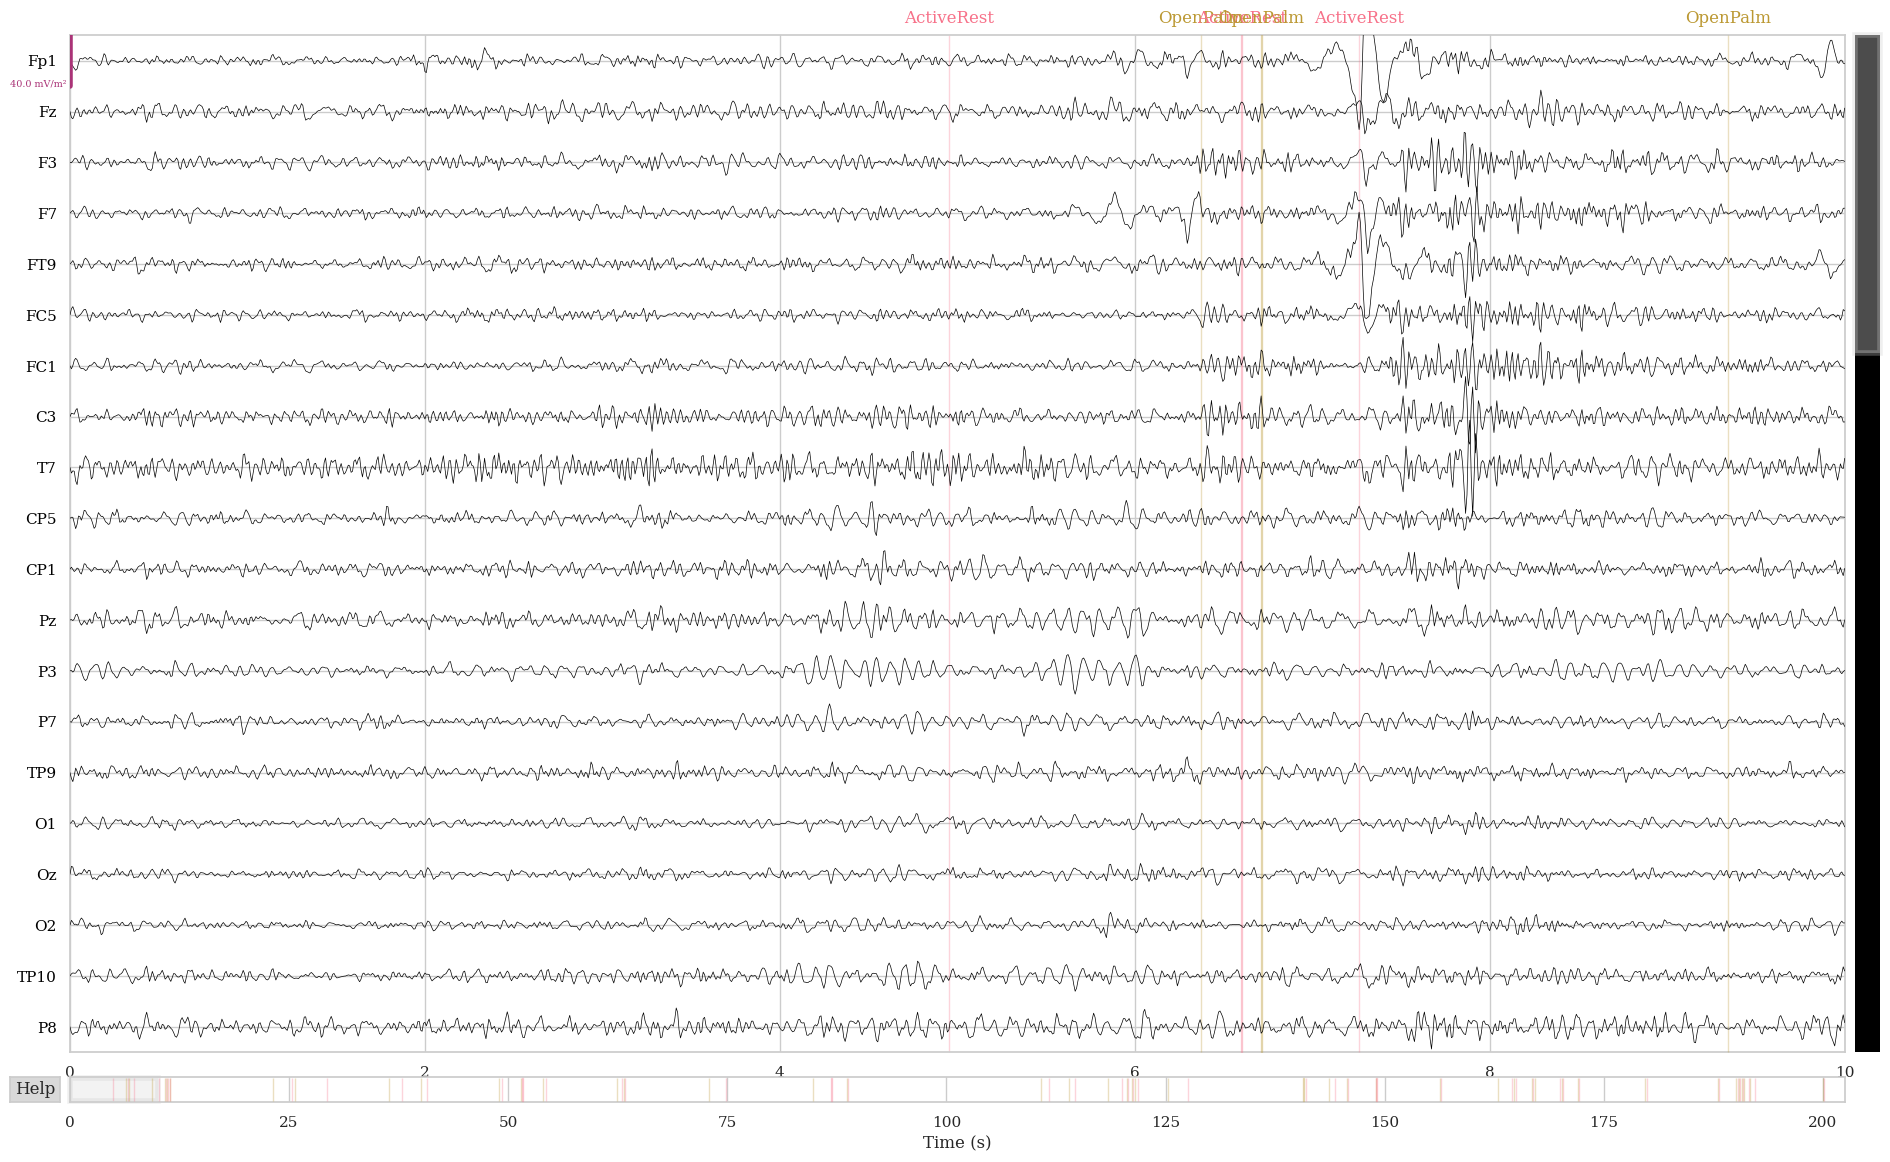

In [38]:
Raw_for_analysis=mne.io.RawArray(storage_concat_data.T,Info)
Raw_for_analysis.set_annotations(stream_annotations)
# Rename channels
Raw_for_analysis.rename_channels(channel_mapping)
#mne.rename_channels(Raw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
Raw_for_analysis.drop_channels(['ACC_X','ACC_Y','ACC_Z']) ## Drop non eeg channels
Raw_for_analysis.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)
Raw_for_analysis._data /= 1e6
Raw_for_analysis = mne.preprocessing.compute_current_source_density(Raw_for_analysis) ## Compute CSD
Raw_for_analysis = Raw_for_analysis.filter(5, 35, method='fir')
Raw_for_analysis.plot()

In [49]:
Raw_for_analysis.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,68 points
Good channels,64 Current source density
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,5.00 Hz
Lowpass,35.00 Hz


In [29]:
predictions_proba

[array([[4.35163072e-14, 1.00000000e+00, 7.84815158e-13]]),
 array([[2.29819141e-06, 9.99988955e-01, 8.74688123e-06]]),
 array([[0.80726741, 0.13619253, 0.05654006]]),
 array([[0.97317917, 0.01134348, 0.01547735]]),
 array([[0.94513928, 0.01610752, 0.0387532 ]]),
 array([[0.74363352, 0.0735587 , 0.18280779]]),
 array([[0.89733893, 0.01794598, 0.08471508]]),
 array([[0.62539582, 0.0439906 , 0.33061358]]),
 array([[0.66279908, 0.12053803, 0.21666289]]),
 array([[0.63960509, 0.10826489, 0.25213002]]),
 array([[0.45670566, 0.3621206 , 0.18117373]]),
 array([[0.07976596, 0.76774966, 0.15248438]]),
 array([[0.06559015, 0.81627191, 0.11813794]]),
 array([[0.07649235, 0.75728029, 0.16622736]]),
 array([[0.14782541, 0.63988166, 0.21229293]]),
 array([[0.17889464, 0.66584075, 0.1552646 ]]),
 array([[0.18073695, 0.56532   , 0.25394305]]),
 array([[0.23937772, 0.45140028, 0.309222  ]]),
 array([[0.28404613, 0.39395465, 0.32199921]]),
 array([[0.32396532, 0.39857258, 0.2774621 ]]),
 array([[0.32296

In [185]:
Raw.plot()

In [11]:
Info = mne.create_info (sinfo.n_channels,sinfo.sfreq,'eeg')
Raw=mne.io.RawArray(concat_data.T,Info)

NameError: name 'concat_data' is not defined

In [152]:
filtered_data_band_passed

[<RawArray | 20 x 10120 (20.2 s), ~1.6 MB, data loaded>,
 <RawArray | 20 x 10120 (20.2 s), ~1.6 MB, data loaded>,
 <RawArray | 20 x 10120 (20.2 s), ~1.6 MB, data loaded>,
 <RawArray | 20 x 10120 (20.2 s), ~1.6 MB, data loaded>]

In [19]:
Raw._data /= 1e6

In [184]:

Raw_CSD_Filtered.plot()

In [153]:
filtered_data_band_passed = []
for i,(LowPass,HighPass) in enumerate(filters_bands):
    unfiltered_Raw_CSD=Raw_CSD_Filtered.copy()
    Raw_CSD_Filtered_band= unfiltered_Raw_CSD.filter(LowPass, HighPass, method='fir')
    filtered_data_band_passed.append(Raw_CSD_Filtered_band)



AttributeError: 'list' object has no attribute 'get_data'

In [12]:
# Define paths: 
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'

OriginalRaw=read_raw_xdf(recording_path / 'NH_Block_3.xdf')


NameError: name 'read_raw_xdf' is not defined

In [64]:
unfiltered_Raw=Raw.copy()
unfiltered_OriginalRaw=OriginalRaw.copy()

Raw_Filtered = unfiltered_Raw.filter(8, 32, method='fir')
OriginalRaw_Filtered = unfiltered_OriginalRaw.filter(8, 32, method='fir')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.6s finished


In [61]:

# Assuming 'raw' is your Raw MNE data instance
sfreq = 500  # Sampling frequency
tmin = 80  # Start time in seconds
tmax = 105  # End time in seconds

# Calculate start and end sample indices
start_sample = int(tmin * sfreq)
end_sample = int(tmax * sfreq)

# Crop the raw data
OriginalRawCropped = OriginalRaw_Filtered.copy().crop(tmin=tmin, tmax=tmax)

# Now 'raw_cropped' contains the segment of the data from 90 to 115 seconds


In [44]:
OriginalRawCroppedData = OriginalRawCropped.get_data()
LSLData = Raw.get_data()

In [60]:
unfiltered_Raw=Raw.copy()
unfiltered_OriginalRaw=OriginalRaw.copy()

Raw_Filtered = unfiltered_Raw.filter(8, 32, method='iir')
OriginalRaw_Filtered = unfiltered_OriginalRaw.filter(8, 32, method='iir')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 32 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 32.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 32 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 32.00 Hz: -6.02, -6.02 dB



In [64]:
OriginalRawCroppedData = OriginalRawCropped.get_data()
LSLData = Raw_Filtered.get_data()

In [65]:
display(OriginalRawCroppedData[0,:])

array([-2.05663489e-06, -1.62567150e-06, -9.81545734e-07, -1.77730737e-07,
        7.12710861e-07,  1.60916388e-06,  2.43667556e-06,  3.13736926e-06,
        3.67749743e-06,  4.04879166e-06,  4.26438991e-06,  4.35106154e-06,
        4.34020119e-06,  4.25992787e-06,  4.12980060e-06,  3.95861057e-06,
        3.74487173e-06,  3.47918372e-06,  3.14750699e-06,  2.73445192e-06,
        2.22592100e-06,  1.61086603e-06,  8.82433267e-07,  3.91483631e-08,
       -9.13186995e-07, -1.95862862e-06, -3.06769785e-06, -4.19460244e-06,
       -5.27659343e-06, -6.23686196e-06, -6.99171276e-06, -7.46165118e-06,
       -7.58475841e-06, -7.32967177e-06, -6.70500305e-06, -5.76238053e-06,
       -4.59153847e-06, -3.30773987e-06, -2.03376073e-06, -8.80091464e-07,
        7.24787938e-08,  7.84241799e-07,  1.25964471e-06,  1.54170121e-06,
        1.69933113e-06,  1.81068797e-06,  1.94613748e-06,  2.15421535e-06,
        2.45286919e-06,  2.82699306e-06,  3.23204834e-06,  3.60261009e-06,
        3.86402425e-06,  

In [59]:
display(LSLData[0,:])

array([-4.23633359e-09,  7.97463193e-07,  1.37292660e-06,  1.54129221e-06,
        1.20371265e-06,  3.64042635e-07, -8.70299372e-07, -2.30731870e-06,
       -3.70545740e-06, -4.81778963e-06, -5.43695147e-06, -5.43244810e-06,
       -4.77369435e-06, -3.53506973e-06, -1.88274619e-06, -4.63174873e-08,
        1.71931957e-06,  3.17512209e-06,  4.13526545e-06,  4.49474970e-06,
        4.24300891e-06,  3.46169500e-06,  2.30754142e-06,  9.83763778e-07,
       -2.94660519e-07, -1.33562965e-06, -1.99859888e-06, -2.21289019e-06,
       -1.98343518e-06, -1.38415575e-06, -5.41191898e-07,  3.90516149e-07,
        1.25321993e-06,  1.91090585e-06,  2.26889333e-06,  2.28589564e-06,
        1.97715165e-06,  1.40862980e-06,  6.83699921e-07, -7.52011795e-08,
       -7.46752831e-07, -1.22955957e-06, -1.45675668e-06, -1.40430322e-06,
       -1.09188748e-06, -5.76717318e-07,  5.80965045e-08,  7.17812860e-07,
        1.30999908e-06,  1.75574622e-06,  1.99687327e-06,  1.99900122e-06,
        1.75128733e-06,  

In [ ]:
Raw_Filtered.plot()

Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


: 

In [38]:

def array_in_array(small, large):
    for i in range(large.shape[0] - small.shape[0] + 1):
        for j in range(large.shape[1] - small.shape[1] + 1):
            # Extracting the slice of the larger array to compare
            slice_of_large = large[i:i+small.shape[0], j:j+small.shape[1]]
            if np.array_equal(slice_of_large, small):
                return True, (i, j)  # Found the small array, return True and the starting position
    return False, None  # Small array not found

# This is just a demonstration and might not be practical for very large arrays
exists, position = array_in_array(DS [ 2:5, :], Raw.get_data())
print(f"Exists: {exists}, Position: {position}")

Exists: True, Position: (2, 0)


## LSL clock

The local system timestamp is retrieved with :func:`~mne_lsl.lsl.local_clock`. This
local timestamp can be compared with the LSL timestamp from acquired data.



In [48]:
now = local_clock()
print(f"Timestamp of the acquired data: {ts}")
print(f"Current time: {now}")
print(f"Delta: {now - ts} seconds")

Timestamp of the acquired data: 62361.6523904
Current time: 62382.5415168
Delta: 20.889126400004898 seconds


In [55]:
inlet.samples_available

5482

## Free resources

When you are done with a :class:`~mne_lsl.lsl.StreamInlet` or
:class:`~mne_lsl.lsl.StreamOutlet`, don't forget to free the resources they both use.



In [37]:
inlet.close_stream()
del inlet


NameError: name 'inlet' is not defined